In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from prophet import Prophet

In [5]:
# Preprocessing

df = pd.read_csv('bike_sharing_training.csv')
df.rename(columns={'cnt': 'y', 'dteday': 'ds'}, inplace=True)

df['ds'] = pd.to_datetime(df['ds'], format='%m/%d/%Y')
df[['weathersit_2', 'weathersit_3']] = pd.get_dummies(df['weathersit'], drop_first=True)
df.drop(columns=['instant', 'season', 'yr', 'mnth', 'weekday', 'casual', 'registered', 'weathersit'], 
        inplace=True)  # Remove unneeded variables

df.set_index('ds', inplace=True)
df.index.freq = 'D'

## Exploratory Data Analysis

In [ ]:
plt.figure(figsize=(10, 5))
df['y'].plot()


In [6]:
# Which factors are correlated with the daily count of shared bikes?

df.corr()[['y']].sort_values('y', ascending=False)

,y
y,1.000000
atemp,0.633885
temp,0.631649
workingday,0.048162
holiday,-0.058080
hum,-0.101409
weathersit_2,-0.166746
windspeed,-0.234871
weathersit_3,-0.234874


In [7]:
#What is the significance level of the variable associations with y?

{'atemp': pearsonr(df['y'], df['atemp'])[1], \
'temp': pearsonr(df['y'], df['temp'])[1], \
'windspeed': pearsonr(df['y'], df['windspeed'])[1], \
'hum': pearsonr(df['y'], df['hum'])[1]}

{'atemp': 4.808082149653414e-80,
 'temp': 2.509739779638358e-79,
 'windspeed': 3.059749631870947e-10,
 'hum': 0.007207881612862172}

In [11]:
# What is the mean count for each weathersit?
df.pivot_table(index=['weathersit_2', 'weathersit_3'], values='y', aggfunc='mean').reset_index()

,weathersit_2,weathersit_3,y
0,False,False,4881.733925
1,False,True,1871.400000
2,True,False,4065.508696


In [12]:
# What is the significance level of the difference of the means? (For weathersits 2 and 3) 
f_oneway(df[df['weathersit_2'] == True]['y'], 
         df[df['weathersit_3'] == True]['y'])[1]

2.9835810336290415e-07

In [13]:
# What is the mean count for each workingday status?
df.pivot_table(index='workingday', values='y', aggfunc='mean')

,y
workingday,
0,4390.457014
1,4591.387500


In [14]:
# What is the significance level of the difference of the means?
f_oneway(df[df['workingday'] == 1]['y'], 
         df[df['workingday'] == 0]['y'])[1]

0.20279756941426727

In [17]:
# What is the mean count for each workingday status?
df.pivot_table(index='holiday', values='y', aggfunc='mean')

,y
holiday,
0,4547.334802
1,3871.100000


In [18]:
# What is the significance level of the difference of the means?
f_oneway(df[df['holiday'] == 1]['y'], 
         df[df['holiday'] == 0]['y'])[1]

0.12446261388088206

In [ ]:
y_decompose = seasonal_decompose(df['y'], model='additive',
                   period=7)

y_decompose.plot()
plt.show()

In [ ]:
y_decompose.seasonal[:7].plot()

In [ ]:
plot_acf(df['y'], lags=100)
plot_pacf(df['y'], lags=20)
plt.show()

In [20]:
def add_holiday(holiday, holiday_date):

    if holiday_date.__class__ == str:
        ds = pd.to_datetime(['2011-'+holiday_date, '2012-'+holiday_date])
    
    elif holiday_date.__class__ == list:
        ds = pd.to_datetime(holiday_date)
    
    elif holiday_date.__class__ == pd.core.indexes.datetimes.DatetimeIndex:
        ds = holiday_date

    holiday_df = pd.DataFrame({'holiday': holiday,
                              'ds': ds,
                              'lower_window': -3,
                              'upper_window': 3})
    
    return holiday_df

In [21]:
gen_holidays = add_holiday('gen_holi', df[df['holiday']==1].index)
xmas = add_holiday('christmas', '12-24')
nye = add_holiday('new_year', '12-31')
easter = add_holiday('easter', ['2011-04-24', '2012-04-08'])

#Combine holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter]).set_index('ds')

holidays.sort_index()#.asfreq('D')

,holiday,lower_window,upper_window
ds,,,
2011-01-17,gen_holi,-3,3
2011-02-21,gen_holi,-3,3
2011-04-15,gen_holi,-3,3
2011-04-24,easter,-3,3
2011-05-30,gen_holi,-3,3
2011-07-04,gen_holi,-3,3
2011-09-05,gen_holi,-3,3
2011-10-10,gen_holi,-3,3
2011-11-11,gen_holi,-3,3


In [31]:
holidays.reset_index(inplace=True)
df.reset_index(inplace=True)

## Prophet Model

In [38]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

model.add_regressor('workingday')
model.add_regressor('atemp')
model.add_regressor('temp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weathersit_2')
model.add_regressor('weathersit_3')

model.fit(df)

23:16:48 - cmdstanpy - INFO - Chain [1] start processing
23:16:48 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
from prophet.utilities import regressor_coefficients

In [47]:
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,workingday,multiplicative,0.000000,0.192619,0.192619,0.192619
1,atemp,multiplicative,0.480847,0.259935,0.259935,0.259935
2,temp,multiplicative,0.502732,0.790121,0.790121,0.790121
3,hum,multiplicative,0.625717,-0.403661,-0.403661,-0.403661
4,windspeed,multiplicative,0.190534,-0.642103,-0.642103,-0.642103
5,weathersit_2,multiplicative,0.000000,-0.103346,-0.103346,-0.103346
6,weathersit_3,multiplicative,0.000000,-0.474217,-0.474217,-0.474217


In [48]:
from prophet.diagnostics import cross_validation

# Apply CV to the model

df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')

df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8161.609034,7416.986356,8887.418650,6211,2012-06-19
1,2012-06-21,8677.305824,7940.325449,9387.872198,5905,2012-06-19
2,2012-06-22,8307.213218,7595.327518,9059.438752,5823,2012-06-19
3,2012-06-23,7915.684165,7210.984566,8614.416553,7458,2012-06-19
4,2012-06-24,7985.677175,7290.922657,8708.559055,6891,2012-06-19
...,...,...,...,...,...,...
295,2012-11-27,3906.067040,3111.245170,4755.401223,3959,2012-11-01
296,2012-11-28,5611.999471,4771.389680,6453.764057,5260,2012-11-01
297,2012-11-29,5939.212987,5096.629323,6740.582590,5323,2012-11-01
298,2012-11-30,5975.690167,5159.811919,6790.697432,5668,2012-11-01


In [57]:
from prophet.diagnostics import performance_metrics
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.597244e+06,1263.821039,939.245674,0.163389,0.091621,0.157160,0.566667
1,4 days,1.501296e+06,1225.273723,908.029595,0.150917,0.080634,0.147562,0.600000
2,5 days,1.536337e+06,1239.490507,963.052176,0.155815,0.079182,0.151991,0.533333
3,6 days,1.195584e+06,1093.427410,891.684744,0.139546,0.107843,0.141157,0.566667
4,7 days,1.224209e+06,1106.439569,881.654890,0.134088,0.116177,0.139813,0.566667
5,8 days,9.838329e+05,991.883514,773.432046,0.109555,0.109402,0.119039,0.600000
6,9 days,9.626402e+05,981.142280,770.462293,0.107338,0.105244,0.115423,0.533333
7,10 days,1.445832e+06,1202.427465,924.220197,0.133360,0.122353,0.137158,0.466667
8,11 days,1.584757e+06,1258.871371,962.283457,0.143870,0.111656,0.144967,0.500000
9,12 days,2.089221e+06,1445.413708,1131.419074,4.080852,0.122084,0.224426,0.466667


In [61]:
{'rmse': performance_metrics(df_cv)['rmse'].mean(),
 'mape': performance_metrics(df_cv)['mape'].mean()}

{'rmse': 1315.4980955393605, 'mape': 1.0109915165794365}

c:\Users\User\scripts\time_series\.venv\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\User\scripts\time_series\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


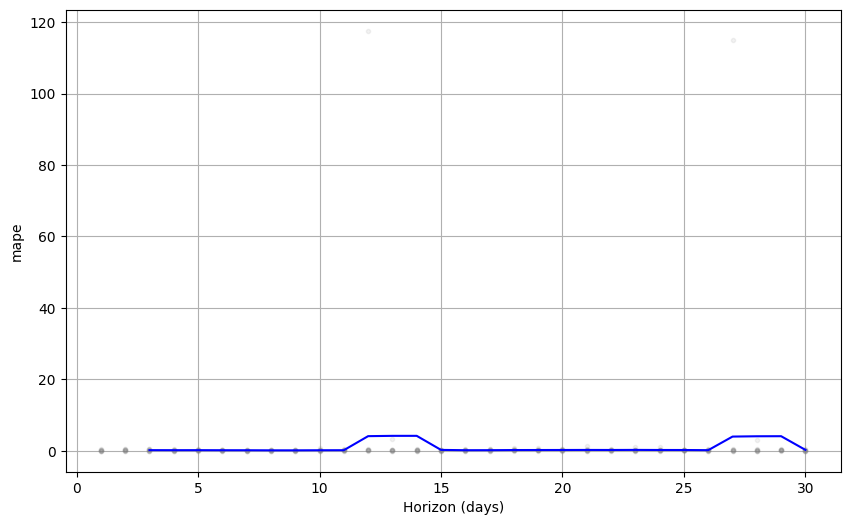

In [63]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='mape');

In [65]:
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']

In [74]:
df_cv['deviation_%'] = (df_cv['yhat'] / df_cv['y']) - 1
df_cv.sort_values('deviation_%', ascending=False).head(10)

# On October 29th, 2012, Hurricane Sandy assaulted Washington D.C.

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_%
251,2012-10-29,2609.789308,1813.059286,3393.652848,22,2012-10-17,2587.789308,117.626787
236,2012-10-29,2550.056365,1752.978189,3333.896850,22,2012-10-02,2528.056365,114.911653
252,2012-10-30,4720.799329,3945.249805,5493.980746,1096,2012-10-17,3624.799329,3.307299
237,2012-10-30,4456.589060,3650.930998,5186.963291,1096,2012-10-02,3360.589060,3.066231
290,2012-11-22,5858.668431,5000.340810,6712.149656,2425,2012-11-01,3433.668431,1.415946
292,2012-11-24,4953.507623,4104.399135,5772.247112,2277,2012-11-01,2676.507623,1.175454
293,2012-11-25,4648.901405,3892.557740,5442.706166,2424,2012-11-01,2224.901405,0.917864
17,2012-07-07,8618.714399,7898.587121,9309.177989,4840,2012-06-19,3778.714399,0.780726
18,2012-07-08,8258.626949,7561.546469,8935.900459,4672,2012-06-19,3586.626949,0.767686
9,2012-06-29,9076.154356,8327.691486,9812.175542,5463,2012-06-19,3613.154356,0.661386


In [78]:
df.loc[df['ds']=='2012-10-29', 'y'] = df.loc[df['ds']=='2012-10-28', 'y']
df.loc[df['ds']=='2012-10-30', 'y'] = df.loc[df['ds']=='2012-10-28', 'y']

In [79]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

model.add_regressor('workingday')
model.add_regressor('atemp')
model.add_regressor('temp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weathersit_2')
model.add_regressor('weathersit_3')

model.fit(df)

00:10:05 - cmdstanpy - INFO - Chain [1] start processing
00:10:05 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
from prophet.diagnostics import cross_validation

# Apply CV to the model

df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')

df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8140.866694,7411.670089,8878.502907,6211.0,2012-06-19
1,2012-06-21,8665.003011,7934.962521,9352.523566,5905.0,2012-06-19
2,2012-06-22,8294.166726,7574.168753,8966.844508,5823.0,2012-06-19
3,2012-06-23,7892.907038,7202.307474,8616.677596,7458.0,2012-06-19
4,2012-06-24,7953.115337,7206.519489,8650.393601,6891.0,2012-06-19
...,...,...,...,...,...,...
291,2012-11-27,4013.447429,3147.390460,4797.165968,3959.0,2012-11-01
292,2012-11-28,5612.771965,4779.004672,6387.699135,5260.0,2012-11-01
293,2012-11-29,5944.461557,5111.688453,6731.202821,5323.0,2012-11-01
294,2012-11-30,6001.749958,5188.546750,6790.087427,5668.0,2012-11-01


In [81]:
{'rmse': performance_metrics(df_cv)['rmse'].mean(),
 'mape': performance_metrics(df_cv)['mape'].mean()}

{'rmse': 1271.675539014073, 'mape': 0.16003718465968592}

c:\Users\User\scripts\time_series\.venv\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\User\scripts\time_series\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


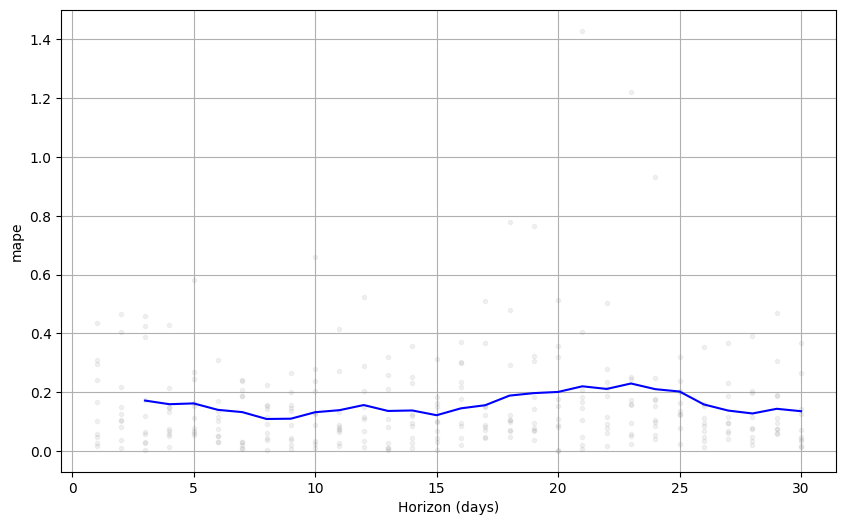

In [82]:
plot_cross_validation_metric(df_cv, metric='mape');